# 从0开始的RNN-序列模型
例如时序模型，研究对象是时间坐标系下发生的一系列事件，称为事件序列，目前考虑最简单的情况。也即对于一个随时间变化的事件，他的某一状态可用数值进行描述，对于时间坐标轴，将其进行等量刻度划分形成一系列的时间槽，将每个时间槽中事件状态数值记录下来就形成了一个序列，针对这一序列进行拟合与推理的模型就是接下来将要讨论的序列模型。

在此之前，我们研究的对象包含一个特征和标签，特征也被称为特征向量，它包含了多个用于描述对象的分量，例如对于房子，有面积、层数等等，对于图像，把每一个像素值都作为一个特征分量，与此同时标签是对物体感兴趣的特征的一个描述，例如房子的价格、图像里是否包含猫、图像数字识别分类等等。因而针对一个完整的数据样本，其特征的n个分量构成n个维度张成一个n维特征空间，标签则作为独立于特征空间的分量，整体上是n+1维度的空间，特征分量值构成坐标，标签值构成值，整体上一个样本就是这一空间中的一点。简言之，预测值独立于特征的值。

对于即将研究的时间状态序列，其特征空间是一维的，正向流动的，也即时间维，序列值作为研究对象可以是一个向量，简单起见先讨论单值的情况，例如股票价格随时间的变化序列。那么，对于当前t时刻的值$x_t$，类似于之前的标签值，拟合模型输入是之前的k个时刻（或者前面所有的值，k可取1），即$x_{t-1}, ..., x_{t-k}$，这被称为自回归模型（也可以是分类变量），模型由以下公式给出
$x_t \sim P(x_t \mid x_{t-1}, \ldots, x_1).$
整个序列预测值由以下公式给出
$P(x_1, \ldots, x_T) = \prod_{t=1}^T P(x_t \mid x_{t-1}, \ldots, x_1).$
结合马尔可夫条件，也即仅与前k个特别是仅与前一个值相关，公式化为
$P(x_1, \ldots, x_T) = \prod_{t=1}^T P(x_t \mid x_{t-1}) \text{ 当 } P(x_1 \mid x_0) = P(x_1).$
据此计算$P(x_{t+1} \mid x_{t-1})$有:
$\begin{split}\begin{aligned}
P(x_{t+1} \mid x_{t-1})
&= \frac{\sum_{x_t} P(x_{t+1}, x_t, x_{t-1})}{P(x_{t-1})}\\
&= \frac{\sum_{x_t} P(x_{t+1} \mid x_t, x_{t-1}) P(x_t, x_{t-1})}{P(x_{t-1})}\\
&= \sum_{x_t} P(x_{t+1} \mid x_t) P(x_t \mid x_{t-1})
\end{aligned}\end{split}$


In [1]:
import torch
from torch import nn
import sys
sys.path.append("../")
from MyUtils import d2laiUtils as d2l

## 自回归模型的训练
使用前k个数据预测当前时刻的数据，同时使用正弦函数作为模拟对象

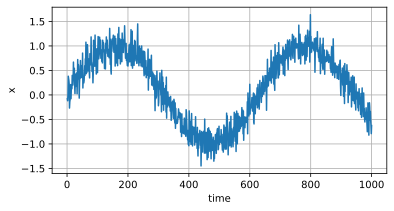

In [40]:
# 生成模拟训练数据
T = 1000
noise = 0.2
time = torch.arange(1, T+1, dtype=torch.float32)
x = torch.sin(0.01*time)+torch.normal(0.0, noise, (T,))
d2l.plot(time, x, 'time', 'x', figsize=(6, 3))

接下来，我们将这个序列转换为模型的“特征－标签”（feature-label）对。 基于嵌入维度$\tau$，我们将数据映射为数据对$y_t = x_t$和$\mathbf{x}_t = [x_{t-\tau}, \ldots, x_{t-1}]$。 你可能已经注意到，这比我们提供的数据样本少了$\tau$个， 因为我们没有足够的历史记录来描述前$\tau$个数据样本。 一个简单的解决办法是：如果拥有足够长的序列就丢弃这几项； 另一个方法是用零填充序列。 在这里，我们仅使用前600个“特征－标签”对进行训练。

In [36]:
from torch.utils import data
# 将序列转为 "特征-标签" 的形式
def get_data_iter(tau, batch_size, n_train):
    features = torch.zeros((T-tau, tau))
    for i in range(tau):
        features[:, i] = x[i:T-tau+i]
    labels = x[tau:].reshape(-1, 1)
    # 再把tensor转为dataset模式
    train_set = data.TensorDataset(features[:n_train], labels[:n_train])
    train_iter = data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    return features, labels, train_iter

使用一个相当简单的架构训练模型： 一个拥有两个全连接层的多层感知机，ReLU激活函数和平方损失

In [37]:
# 搭建一个简单的模型
def init_m(m):
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight)
def get_net(tau):
    net = nn.Sequential(nn.Linear(tau, 5), nn.ReLU(), nn.Linear(5, 1))
    net.apply(init_m)
    return net
loss = nn.MSELoss(reduction="none")

接下来就是训练环节

In [38]:
def train(train_iter, net, epoch_num, lr):
    optim = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epoch_num):
        tl, tn = 0.0, 0.0
        for X, y in train_iter:
            l = loss(net(X), y)
            tl += float(l.sum())
            tn += len(y)
            optim.zero_grad()
            l.sum().backward()
            optim.step()
        with torch.no_grad():
            print(f"In epoch {epoch+1:02d}, loss={tl/tn:.5f}")
    return net


首先是检查模型预测下一个时间步的能力， 也就是**单步预测（one-step-ahead prediction）**

In epoch 01, loss=0.26135
In epoch 02, loss=0.06694
In epoch 03, loss=0.05589
In epoch 04, loss=0.05315
In epoch 05, loss=0.05786


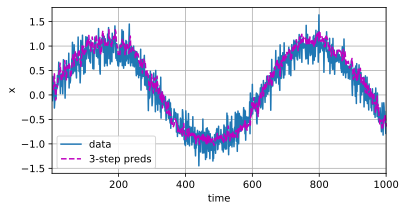

In [48]:
# 指定参数，训练模型，画出对比曲线
tau, batch_size, n_train, epoch_num, lr = 4, 20, 600, 5, 0.03
features, labels, train_iter = get_data_iter(tau, batch_size, n_train)
net3 = train(train_iter, get_net(tau), epoch_num, lr)
y3 = net3(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), y3.detach().numpy()], 'time',
         'x', legend=['data', '3-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

## 多步预测
正如我们所料，单步预测效果不错。 即使这些预测的时间步超过了604（n_train + tau）， 其结果看起来仍然是可信的。注意到，这是由于输入都是原始的输入，即使是在时间步t超过600的情况下，假设当n>600时x未知，那么此后的输出应依据前tau个预测值的基础上进行预测
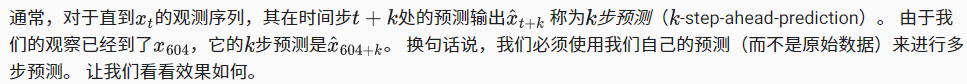

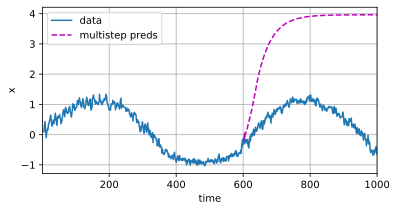

In [52]:
mstep_preds = torch.zeros(T)
mstep_preds[:n_train] = x[:n_train]
for i in range(n_train, T):
    mstep_preds[i] = net3(mstep_preds[i-tau:i].reshape((1, -1)))
d2l.plot([time[tau:], time[n_train:]], 
         [y3.detach().numpy(), mstep_preds[n_train:].detach().numpy()], 
        'time', 'x', legend=['data', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

可见，随着时间步的增加，预测值与真实值的差距越来越大，并且很快就会衰减到一个常数——这是显而易见的。接下来，控制预测值偏离真实值的步长k，设置最大步长max_steps=64(而不是无限制的增长下去)

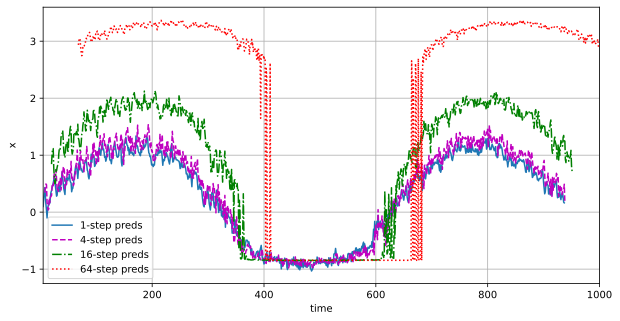

In [54]:
max_steps = 64
features = torch.zeros((T-tau-max_steps+1, tau+max_steps))
# 对于前tau列, 均为已知值
for i in range(tau):
    features[:, i] = x[i:T-tau-max_steps+1+i]
# 对于后面的列，使用前τ列进行预测
for i in range(tau, tau+max_steps):
    features[:, i] = net3(features[:, i-tau:i]).reshape(-1)
steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 
         'time', 'x', legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(10, 5))